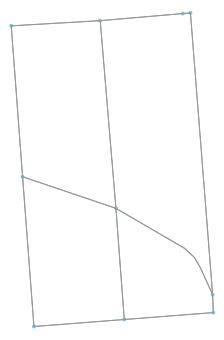

(<Figure size 352.069x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f4d3f32ecc0>)

In [322]:
import numpy as np
import osmnx as ox
import networkx as nx
from shapely.geometry import Point, Polygon, LineString

# BUILD GRAPH

# set bbox bounds: (will eventually come from drawing)

north = 37.7599 # max lat 
south = 37.7569 # min lat
east = -122.3997 # max lng
west = -122.4023 # min lng 
 
# create graph
G = ox.graph_from_bbox(north, south, east, west, network_type='walk')

# display graph
ox.plot_graph(G)


In [323]:
# Get graph info 

basic_stats = ox.basic_stats(G)
    
print("\n n (number of nodes in the graph):", basic_stats['n'])
print("\n m (number of edges in the graph):", basic_stats['m']/2) # because it's an undirected graph
print("\n street_length_total (sum in meters):", basic_stats['street_length_total']/2)



 n (number of nodes in the graph): 10

 m (number of edges in the graph): 13.0

 street_length_total (sum in meters): 710.483


In [261]:
# GET graph data frames
nodes, edges = ox.graph_to_gdfs(G) # make two dataframes - one for nodes and one for edges

# Edges table
edges

# REF:
# geometry
# highway tag
# length (meters)
# name
# osmid - of the way that the edge is part of, not just of the section
# u - start node
# v - end node 

,geometry,highway,key,length,name,oneway,osmid,u,v
0,"LINESTRING (-122.4020923 37.7596792, -122.4019...",residential,0,143.868,Rhode Island Street,False,84805680,65294613,65294615
1,"LINESTRING (-122.4020923 37.7596792, -122.4011...",residential,0,84.738,20th Street,False,224384045,65294613,65320188
2,"LINESTRING (-122.4019697 37.758389, -122.40096...",residential,0,93.711,Southern Heights Avenue,False,8919494,65294615,65320191
3,"LINESTRING (-122.4019697 37.758389, -122.40184...",residential,0,142.851,Rhode Island Street,False,84805680,65294615,65294616
4,"LINESTRING (-122.4019697 37.758389, -122.40209...",residential,0,143.868,Rhode Island Street,False,84805680,65294615,65294613
5,"LINESTRING (-122.4018467 37.757108, -122.40086...",residential,0,86.158,22nd Street,False,28669973,65294616,65320193
6,"LINESTRING (-122.4018467 37.757108, -122.40196...",residential,0,142.851,Rhode Island Street,False,84805680,65294616,65294615
7,"LINESTRING (-122.40096 37.7581188, -122.401969...",residential,0,93.711,Southern Heights Avenue,False,8919494,65320191,65294615
8,"LINESTRING (-122.40096 37.7581188, -122.400869...",residential,0,106.023,De Haro Street,False,224384013,65320191,65320193
9,"LINESTRING (-122.40096 37.7581188, -122.40113 ...",residential,0,179.060,De Haro Street,False,224384013,65320191,65320188


In [257]:
nodes

,osmid,x,y,geometry
65294613,65294613,-122.402092,37.759679,POINT (-122.4020923 37.7596792)
65294615,65294615,-122.401970,37.758389,POINT (-122.4019697 37.758389)
65294616,65294616,-122.401847,37.757108,POINT (-122.4018467 37.757108)
65320191,65320191,-122.400960,37.758119,POINT (-122.40096 37.7581188)
65320193,65320193,-122.400870,37.757168,POINT (-122.4008696 37.757168)
65313453,65313453,-122.400154,37.759790,POINT (-122.4001542 37.7597898)
65313455,65313455,-122.399914,37.757380,POINT (-122.399914 37.7573804)
65313458,65313458,-122.399907,37.757227,POINT (-122.3999067 37.7572271)
3074358133,3074358133,-122.400235,37.759784,POINT (-122.4002355 37.7597842)
65320188,65320188,-122.401130,37.759723,POINT (-122.40113 37.7597235)


In [460]:
# FIND ODD NODES 

# figure out how many edges, (u,v) pairs, include each node   

# initialized dictionary to add nodes to
nodes_dict = {}

# add each node as key in dict 
for node in G.nodes:
    nodes_dict[node] = set() # using a set so the same edge, reordered, cannot be added -- avoid dupes
    
# confirm that the dict has the expected number of nodes 

expected_node_count = basic_stats['n']
actual_node_count = len(nodes_dict.keys())
print("Confirmed node count:", expected_node_count == actual_node_count)


expected_edge_count = basic_stats['m'] # from directed graph - needs to be divided by 2
edge_counter = 0

for edge in G.edges:
    
    # edge is a three item tuple: (start,end,weight) 
    
    start_node = edge[0]
    end_node = edge[1]
    
    # name edge by start and end node 
    edge = (start_node, end_node) 
    
    # add tuple of (start_node, end_node, edge osmid) to the node - this is the id b/c wayid is not 
    # unique to the edge
    edge_identifier = (start_node, end_node)
    nodes_dict[start_node].add(edge_identifier)
    # edge_counter += 1 # use later to confirm edge count 


print("\nNodes dictionary:\n")
print(nodes_dict)

Confirmed node count: True

Nodes dictionary:

{65294613: {(65294613, 65320188), (65294613, 65294615)}, 65294615: {(65294615, 65294613), (65294615, 65294616), (65294615, 65320191)}, 65294616: {(65294616, 65320193), (65294616, 65294615)}, 65320191: {(65320191, 65320188), (65320191, 65313455), (65320191, 65294615), (65320191, 65320193)}, 65320193: {(65320193, 65313458), (65320193, 65294616), (65320193, 65320191)}, 65313453: {(65313453, 65313455), (65313453, 3074358133)}, 65313455: {(65313455, 65313453), (65313455, 65320191), (65313455, 65313458)}, 65313458: {(65313458, 65313455), (65313458, 65320193)}, 3074358133: {(3074358133, 65320188), (3074358133, 65313453)}, 65320188: {(65320188, 65294613), (65320188, 65320191), (65320188, 3074358133)}}



node: 65294615
edge_count: 3

node: 65320193
edge_count: 3

node: 65313455
edge_count: 3

node: 65320188
edge_count: 3

Odd nodes:
[65294615, 65320193, 65313455, 65320188]





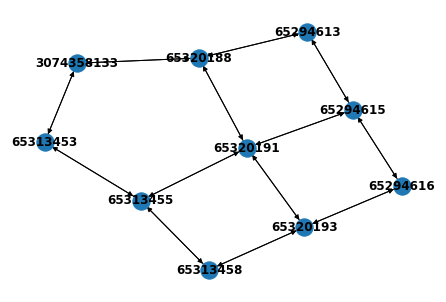

In [570]:
# GET ODD NODES 

# find nodes that have an odd count of assoicated edges

odd_nodes = []

for node in nodes_dict:
    
    edge_count = len(nodes_dict[node])
    
    if edge_count % 2 != 0:
        # compile list of odd nodes 
        print("\nnode:", node)
        # print("edges:", nodes_dict[node])
        print("edge_count:", edge_count)
        odd_nodes.append(node)

print("\nOdd nodes:")
print(odd_nodes)
print("\n\n")

# draw graph for visual check of odd nodes
nx.draw(G, with_labels=True, font_weight='bold')


In [461]:
# GET POSSIBLE COMBINATIONS OF ODD NODES

# notes:
## each option list should be len(odd_node)/2 long

# print(odd_nodes)

#-------EXAMPLE-MESS-AROUND----------# 

alpha_list = ['A','B','C','D']

# op_1 = [(A,B), (C,D)] 
# op_2 = [(A,C), (B,D)]
# op_3 = [(A,D), (B,C)]
# op_4 = [(B,C), (A,D)] # same as op3
# op_5 = [(B,D), (A,C)] # same as op2
# op_6 = [(C,D), (A,B)] # same as op1

# expected result: [
#                   [ (A,B), (C,D) ], 
#                   [ (A,C), (B,D) ], 
#                   [ (A,D), (B,C) ]
#                  ]

# from itertools import combinations

# alpha_list = ['A','B','C','D']

# def get_list_of_unique_pairs(node_list):

#     all_possible_combos_iter = combinations(node_list, 2) # makes an object 

#     list_of_unique_pairs = []

#     for i in all_possible_combos_iter:
#         list_of_unique_pairs.append(i)
#     return(list_of_unique_pairs)

# get_list_of_unique_pairs(alpha_list)



In [597]:
alpha_list = ['A','B','C','D']

# the following is from: https://stackoverflow.com/questions/5360220/how-to-split-a-list-into-pairs-in-all-possible-ways
# need to work more on this 

import itertools

def all_pairs(lst):
    if len(lst) < 2:
        yield []
        return
    if len(lst) % 2 == 1:
        # Handle odd length list
        for i in range(len(lst)):
            for result in all_pairs(lst[:i] + lst[i+1:]):
                yield result
    else:
        a = lst[0]
        for i in range(1,len(lst)):
            pair = (a,lst[i])
            for rest in all_pairs(lst[1:i]+lst[i+1:]):
                yield [pair] + rest

def get_list_of_all_pairs_lists(lst):
    
    list_of_possible_pairs_lists = []
    all_pairs_object = all_pairs(lst)
    
    for pairs_list in all_pairs_object: 
        list_of_possible_pairs_lists.append(pairs_list)
    
    return list_of_possible_pairs_lists
    
# possible_pairings_list = get_list_of_all_pairs_lists(alpha_list)

possible_pairings_list = get_list_of_all_pairs_lists(odd_nodes)

for pair_list in possible_pairings_list:
    print()
    print(pair_list)



[(65294615, 65320193), (65313455, 65320188)]

[(65294615, 65313455), (65320193, 65320188)]

[(65294615, 65320188), (65320193, 65313455)]
[[(65294615, 65320193), (65313455, 65320188)], [(65294615, 65313455), (65320193, 65320188)], [(65294615, 65320188), (65320193, 65313455)]]


In [499]:
# get shortest distance for each pairing 

# example route 

def get_shortest_path_route_two_nodes(start_node, end_node): 
    
    """ return sequenced list of nodes included in route between a given start and end node """

    route = nx.shortest_path(G, start_node, end_node, weight='length') # output is an ordered list of edges 

    #  ref: https://automating-gis-processes.github.io/2017/lessons/L7/network-analysis.html
#     ox.plot_graph_route(G, route, fig_height=10, fig_width=10)
    return route
        
def get_route_edges_from_shortest_path(route):
    """ get all edges needed to build given route"""
    
#     print("route nodes sequence:", route)
#     print()
    
    start_node = route[0]
    end_node = route[-1]
    # get all edges included in route 
    
    involved_edges_list = []
    
    for index in range(len(route)): 
        if index < (len(route)-1):
            curr_edge = tuple(route[index:index+2]) # add two because indexing is non-inclusive
            involved_edges_list.append(curr_edge)
            
    return involved_edges_list


def get_total_length_shortest_path(edges_list):
    """return sum of the distances of a list of edge tuples"""
        
    total_length = 0
    
    for edge in edges_list:
        
        start_node = edge[0]
        end_node = edge[1]
        
        curr_edge = edges.loc[(edges['u'] == start_node) & (edges['v'] == end_node)]
        
        # i think there is something messy with length (maybe a built-in and column name]
        #, so i had to index in a more verbose way?
        
        edge_length = curr_edge['length'].values[0]
        
#         print("edge:", edge)
#         print("length:", edge_length)
        
        total_length = total_length + edge_length
        
    return total_length
            

In [599]:

def get_dict_length_pairings_lists(possible_pairings_list):
    
    """ Take possible pairings list, return dict of pairing and distance 
    
    example input: 
    [
    [(65294615, 65320193), (65313455, 65320188)], 
    [(65294615, 65313455), (65320193, 65320188)], 
    [(65294615, 65320188), (65320193, 65313455)]
    ]
    
    example ouput:
    {
    ((65294615, 65320193), (65313455, 65320188)): 506.546, 
    ((65294615, 65313455), (65320193, 65320188)): 506.546, 
    ((65294615, 65320188), (65320193, 65313455)): 330.56899999999996
    }
    
    """
    
    pairings_lengths_dict = {}
    
    for possible_pairing in possible_pairings_list:
        
        possible_pairing = tuple(possible_pairing)

        # print("current pairing list:", possible_pairing)

        total_pairing_length = 0

        for pair in possible_pairing:

            # print("  current pair:", pair)

            # get shortest path distance for pair
            start_node = pair[0]
            end_node = pair[1]

            route = get_shortest_path_route_two_nodes(start_node, end_node)
            # print("\n   route:", route)

            # get all edges in shortest route
            route_edges_list = get_route_edges_from_shortest_path(route)
            # print("   route edges:", route_edges_list)

            # get total route length
            total_route_length = get_total_length_shortest_path(route_edges_list)
            # print("   total route length:", total_route_length)

            # get total added length for pairings_list
            total_pairing_length = total_pairing_length + total_route_length
        
            # print("\n\nTOTAL PAIRING ADDED LENGTH:", total_pairing_length)
            # print("\n-----------\n")
        
        pairings_lengths_dict[possible_pairing] = total_pairing_length
        
    return pairings_lengths_dict

In [605]:
# GET PAIRING LIST WITH THE SHORTEST ADDED DISTANCE

import math

length_pairings_lists_dict = get_dict_length_pairings_lists(possible_pairings_list)

# print(length_pairings_lists_dict)

def get_optimal_pairing_list_dict(length_pairings_lists_dict):
    
    """ 
    Take a list of odd nodes pairing options (a list of lists), return optimal pairing list. 
    
    """
    
    # initialized optimal dist to infinity 
    
    current_optimal_pairings_list = []
    current_optimal_dist = math.inf 
    
    # look at the added distance for each pairings list
    for pairing in length_pairings_lists_dict:
        
        # update the current optimal dist if the dist for the parings list is less than current optimal dist
        if length_pairings_lists_dict[pairing] < current_optimal_dist:
        
            # if the added distance for the current pairings is less than the current optimal dist,
            # replace the current optimal vars 
            
            # print(pairing, length_pairings_lists_dict[pairing])
            
            current_optimal_dist = length_pairings_lists_dict[pairing]
            current_optimal_pairings_list = pairing
            
    
    # confirm that the current_optimal_pairings_list goes with current_optimal_dist
    
    calc_op_dist = current_optimal_dist
    assoc_op_dist = length_pairings_lists_dict[current_optimal_pairings_list]
    
#     print("TEST: \n  optimal distance is assoc. with optimal pairing:", calc_op_dist == assoc_op_dist)
    
    if calc_op_dist == assoc_op_dist:
    
        return {'optimal_pairing' : current_optimal_pairings_list, 

                'optimal_added_distance' : length_pairings_lists_dict[current_optimal_pairings_list]

    #             ,'twice_traverse_edges' : None # get a list of edges involved in the pairings
               }
        
optimal_pairing_list_dict = get_optimal_pairing_list_dict(length_pairings_lists_dict)

In [594]:
# GET SEQUENCE OF EDGE TRAVERSALS 


def get_edges_list(graph):
    
    initial_edges = list(graph.edges)
        
    initial_edges_cleaned = []
    
    for edge in initial_edges:
        
        cleaned = edge[0:2]
        cleaned_rev = cleaned[::-1]
        
        if cleaned not in initial_edges_cleaned and cleaned_rev not in initial_edges_cleaned:
        
            initial_edges_cleaned.append(cleaned)
    
    if len(initial_edges_cleaned) == (basic_stats['m']/2): # make sure the count of edges is correct
        
        return initial_edges_cleaned
    
def make_dict_of_edge_traversals(initial_edges_list):
    
    """ 
    Take a list of edge tuples and make a dict where the value of 
    each is num of traversals, defaulted to 1
    
    edge : traversals needed
    """
    
    edges_traversals_dict = {}
    
    for edge in initial_edges_list:
        
        edges_traversals_dict[edge] = 1
        
    return edges_traversals_dict
    
    
edge_traversals_dict = make_dict_of_edge_traversals(get_edges_list(G))

for edge in edge_traversals_dict:
    print(edge,":", edge_traversals_dict[edge])

(65294613, 65294615) : 1
(65294613, 65320188) : 1
(65294615, 65320191) : 1
(65294615, 65294616) : 1
(65294616, 65320193) : 1
(65320191, 65320193) : 1
(65320191, 65320188) : 1
(65320191, 65313455) : 1
(65320193, 65313458) : 1
(65313453, 65313455) : 1
(65313453, 3074358133) : 1
(65313455, 65313458) : 1
(3074358133, 65320188) : 1


In [637]:
# get double-back edges 

edge_traversals_dict = make_dict_of_edge_traversals(get_edges_list(G))


def get_all_double_back_edges(optimal_pairing_list_dict):
    
    
    # get tuple of edge tuples for optimal pairings 
    optimal_pairing_edges = optimal_pairing_list_dict['optimal_pairing']

    # initialize list for edges that will need to be traversed twice, based on optimal pairing edges 
    twice_traversal_edges = []
    
    # for each pair in optimal pairings, get all the edges involved in the shorted path between the 
    # origin and destination node of pair
    for pair in optimal_pairing_edges:
        print()
        print("pair:", pair)
        
        route = get_shortest_path_route_two_nodes(pair[0], pair[1])
        
        print("route:", route)
        # get all edges in shortest route
        route_edges_list = get_route_edges_from_shortest_path(route)
        
        print("edges in route:", route_edges_list)
        
        twice_traversal_edges = twice_traversal_edges + route_edges_list

    print("\n\nTwice traversal edges:", twice_traversal_edges)
    
    return twice_traversal_edges



def update_traversal_dict_with_added_edges(twice_traversal_list):
    
    edge_traversals_dict_eulerian = edge_traversals_dict
    
    for edge in twice_traversal_list:
        
        reversed_edge_order = edge[::-1]
        
        if edge in edge_traversals_dict:
        
            edge_traversals_dict_eulerian[edge] += 1
        
        elif reversed_edge_order in edge_traversals_dict:
            
            edge_traversals_dict_eulerian[reversed_edge_order] += 1
        else:
            print("EDGE NOT IN DICT FOR SOME REASON")
        
    return edge_traversals_dict_eulerian
    
    
twice_traversal_list = get_all_double_back_edges(optimal_pairing_list_dict)


edge_traversals_dict_eulerian = update_traversal_dict_with_added_edges(twice_traversal_list) 


for edge in edge_traversals_dict_eulerian:
    print(edge, ":", edge_traversals_dict_eulerian[edge])
    
    



pair: (65294615, 65320188)
route: [65294615, 65294613, 65320188]
edges in route: [(65294615, 65294613), (65294613, 65320188)]

pair: (65320193, 65313455)
route: [65320193, 65313458, 65313455]
edges in route: [(65320193, 65313458), (65313458, 65313455)]


Twice traversal edges: [(65294615, 65294613), (65294613, 65320188), (65320193, 65313458), (65313458, 65313455)]
(65294613, 65294615) : 2
(65294613, 65320188) : 2
(65294615, 65320191) : 1
(65294615, 65294616) : 1
(65294616, 65320193) : 1
(65320191, 65320193) : 1
(65320191, 65320188) : 1
(65320191, 65313455) : 1
(65320193, 65313458) : 2
(65313453, 65313455) : 1
(65313453, 3074358133) : 1
(65313455, 65313458) : 2
(3074358133, 65320188) : 1


4


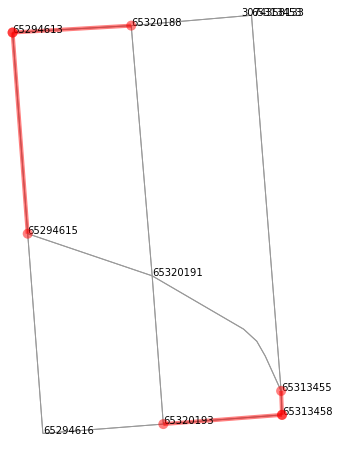

In [656]:
# visualize double_back edges to test - clunky for now

# nx.draw(G, with_labels=True, font_weight='bold')

print(len(twice_traversal_list))

first_added_edge = twice_traversal_list[0]
second_added_edge = twice_traversal_list[1]
third_added_edge = twice_traversal_list[2]
fourth_added_edge = twice_traversal_list[3]

route1 = nx.shortest_path(G, first_added_edge[0], first_added_edge[1], weight='length')
route2 = nx.shortest_path(G, second_added_edge[0], second_added_edge[1], weight='length')
route3 = nx.shortest_path(G, third_added_edge[0], third_added_edge[1], weight='length')
route4 = nx.shortest_path(G, fourth_added_edge[0], fourth_added_edge[1], weight='length')

# plot the routes
# fig, ax = ox.plot_graph_routes(G, [route1, route2], route_color=rc, orig_dest_node_color=nc, node_size=0)
fig, ax = ox.plot_graph_routes(G, 
                               [route1, route2, route3, route4], 
                               route_color='r', 
                               orig_dest_node_color='r', 
                               node_size=0,
                               # axis_off=False,
                               annotate=True,
                               fig_height=8
                              )



In [649]:
ox.plot_graph_routes

<function osmnx.plot.plot_graph_routes(G, routes, bbox=None, fig_height=6, fig_width=None, margin=0.02, bgcolor='w', axis_off=True, show=True, save=False, close=True, file_format='png', filename='temp', dpi=300, annotate=False, node_color='#999999', node_size=15, node_alpha=1, node_edgecolor='none', node_zorder=1, edge_color='#999999', edge_linewidth=1, edge_alpha=1, use_geom=True, orig_dest_points=None, route_color='r', route_linewidth=4, route_alpha=0.5, orig_dest_node_alpha=0.5, orig_dest_node_size=100, orig_dest_node_color='r', orig_dest_point_color='b')>